In [3]:
import os
import numpy as np
import quaternionic
import spherical
import pylab
from copy import copy
from pycbc.types import FrequencySeries, TimeSeries
from pycbc.waveform import get_td_waveform, taper_timeseries
from pycbc.psd import read as psd_read
from pycbc.psd import interpolate as psd_interpolate
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import matched_filter_core, get_cutoff_indices, sigmasq
from scipy.integrate import cumtrapz
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pycbc.waveform.generator import TDomainCBCModesGenerator
%matplotlib inline
import lal
import lalsimulation as lalsim
import RIFT.lalsimutils as lalsimutils
from gwpy.timeseries import TimeSeries as gwpyTimeSeries
from pprint import pprint
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import zoom

from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants that are available
for approx in td_approximants():
    print(approx)

os.environ['LAL_DATA_PATH'] = "/home/jacob.lange/lalsuite-extra/data/lalsimulation/"


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


ModuleNotFoundError: No module named 'RIFT'

In [2]:
def RIFT_lal_binary_black_hole(
    # From Ethan Payne's https://git.ligo.org/ethan.payne/generic-calibration-reweighting/-/blob/master/rift_source.py
        frequency_array, param_args, approx, **kwargs):
    
    waveform_kwargs = dict(
        waveform_approximant=approx, reference_frequency=15.0,
        minimum_frequency=15.0, maximum_frequency=frequency_array[-1], Lmax=5)
    waveform_kwargs.update(kwargs)
    waveform_approximant = waveform_kwargs['waveform_approximant']
    reference_frequency = waveform_kwargs['reference_frequency']
    minimum_frequency = waveform_kwargs['minimum_frequency']
    maximum_frequency = waveform_kwargs['maximum_frequency']
    Lmax = waveform_kwargs['Lmax']
    waveform_dictionary = waveform_kwargs.get(
        'lal_waveform_dictionary', lal.CreateDict()
    )

    approximant = lalsim.GetApproximantFromString(waveform_approximant)

    P = lalsimutils.ChooseWaveformParams()
    P.m1 = param_args['mass_1'] * lal.MSUN_SI
    P.m2 = param_args['mass_2'] * lal.MSUN_SI
    P.s1x = param_args['spin_1x']; P.s1y = param_args['spin_1y']; P.s1z = param_args['spin_1z']
    P.s2x = param_args['spin_2x']; P.s2y = param_args['spin_2y']; P.s2z = param_args['spin_2z']
    P.deltaT = 1./(2*float(maximum_frequency))

    P.fmin = float(minimum_frequency)
    P.fmax = float(maximum_frequency)
    P.fref = float(reference_frequency)
    P.deltaF=frequency_array[1]-frequency_array[0]
    P.incl = param_args['theta_jn']
    P.phiref = param_args['phase']
    P.dist=param_args['luminosity_distance']*lal.PC_SI*1e6
    P.approx = approximant
    P.taper = lalsim.SIM_INSPIRAL_TAPER_START

    hlmT = lalsimutils.hlmoft(P,Lmax=Lmax)
    
    h22T = hlmT[(2,2)]
    
    hplmT = {}
    hclmT = {}
    
    for key,val in hlmT.items():
        hp = lal.CreateREAL8TimeSeries("h(t)", h22T.epoch, h22T.f0, h22T.deltaT, h22T.sampleUnits, h22T.data.length)
        hp.data.data = np.real(val.data.data)
        hc = lal.CreateREAL8TimeSeries("h(t)", h22T.epoch, h22T.f0, h22T.deltaT, h22T.sampleUnits, h22T.data.length)
        hc.data.data = -np.imag(val.data.data)
        hplmT[key] = hp
        hclmT[key] = hc


    return hplmT, hclmT
    
# Create Spherical Harmonics via spherical
# https://github.com/moble/spherical
class Ylm_wrapper:
    def __init__(self, iota=0, phic=0, lmax=5):
        # keep these values for reference
        self.lmax= lmax
        self.iota= iota
        self.phic= phic 
        # initialize d matrix
        self.wigner = spherical.Wigner(5) #lmax = 5
        # get quaternion rep of iota,phic
        self.R = quaternionic.array.from_spherical_coordinates(iota, phic)
        # compute Ylm matrix
        self.Y = self.wigner.sYlm(-2, self.R)
    
    def get_lm(self,l,m):
        # get specific value of Ylm matrix
        return self.Y[self.wigner.Yindex(l,m)]
        
    def get_Aplus_lm(self, l, m):
        # compute Aplus for given l,m
        # compute -2Yl,m and -2Yl,-m
        Ylm = self.get_lm(l, m)
        Ylnm = self.get_lm(l, -m)
        # return coefficients per A5 in Mills and Fairhurst
        return (1 / 2) * (Ylm + (-1) ** l * np.conj(Ylnm))
    
    def get_Across_lm(self, l, m):
        # compute Across for given l,m
        # compute -2Yl,m and -2Yl,-m
        Ylm = self.get_lm(l, m)
        Ylnm = self.get_lm(l, -m)
        # return coefficients per A6 in Mills and Fairhurst
        return (1j / 2) * (Ylm - (-1) ** l * np.conj(Ylnm))
   
def pad_timeseries_to_integer_length(timeseries, sample_rate):
    """
    This function zero pads a time series so that its length is an integer
    multiple of the sampling rate.

    Padding is adding symmetically to the start and end of the time series.
    If the number of samples to pad is odd then the end zero padding will have
    one more sample than the start zero padding.
    """

    # calculate how many sample points needed to pad to get
    # integer second time series
    remainder = sample_rate - len(timeseries) % sample_rate
    start_pad = int(remainder / 2)
    end_pad = int(remainder - start_pad)

    # make arrays of zeroes
    start_array = np.zeros(start_pad)
    end_array = np.zeros(end_pad)

    # pad waveform with arrays of zeroes
    initial_array = np.concatenate([start_array,timeseries,end_array])
    return TimeSeries(initial_array, delta_t=timeseries.delta_t,
                      epoch=timeseries.start_time, dtype=timeseries.dtype)

def pad_to_seglen(timeseries, sample_rate,seglen=8):
    # calculate how many sample points needed to pad to get
    # integer second time series
    remainder = sample_rate*seglen - len(timeseries)
    start_pad = int(remainder / 2)
    end_pad = int(remainder - start_pad)

    # make arrays of zeroes
    start_array = np.zeros(start_pad)
    end_array = np.zeros(end_pad)

    # pad waveform with arrays of zeroes
    initial_array = np.concatenate([start_array,timeseries,end_array])
    return TimeSeries(initial_array, delta_t=timeseries.delta_t,
                      epoch=timeseries.start_time, dtype=timeseries.dtype)

def compute_strain_td(param_args, approx, ifo, delta_t, f_lower, end_time,detector_obj=None):
    """
    Generate strain TimeSeries for IFO 
    """

    hp, hc = get_td_waveform(approximant = approx,
                             mass1 = param_args['mass_1'],
                             mass2 = param_args['mass_2'],
                             spin1z = param_args['spin_1z'],
                             spin1x = param_args['spin_1x'],
                             spin1y = param_args['spin_1y'],
                             spin2z = param_args['spin_2z'],
                             spin2x = param_args['spin_2x'],
                             spin2y = param_args['spin_2y'],
                             inclination = param_args['theta_jn'],
                             coa_phase = param_args['phase'],
                             distance = param_args['luminosity_distance'],
                             mode_array = param_args['mode_array'],
                             f_lower = f_lower,
                             delta_t = delta_t)

    # zero pad polarizations to get integer second time series
    sample_rate = 1./delta_t
    hp = pad_timeseries_to_integer_length(hp, sample_rate)
    hc = pad_timeseries_to_integer_length(hc, sample_rate)
    
    # get Detector instance for IFO
    if detector_obj == None:
        det = Detector(ifo)
    else:
        det = detector_obj

    # get antenna pattern
    fp, fc = det.antenna_pattern(param_args['ra'], param_args['dec'],
            param_args['psi'], end_time)

    # calculate strain
    strain = fp*hp + fc*hc
    strain = pad_timeseries_to_integer_length(strain, sample_rate)


    # taper waveform
    hp = taper_timeseries(hp, tapermethod="TAPER_START")
    hc = taper_timeseries(hc, tapermethod="TAPER_START")
    strain = taper_timeseries(strain, tapermethod="TAPER_START")

    return strain, hp, hc

def compute_hphc_td(param_args, approx, delta_t, f_lower):
    """
    Generate strain TimeSeries for IFO 
    """

    hp, hc = get_td_waveform(approximant = approx,
                             mass1 = param_args['mass_1'],
                             mass2 = param_args['mass_2'],
                             spin1z = param_args['spin_1z'],
                             spin1x = param_args['spin_1x'],
                             spin1y = param_args['spin_1y'],
                             spin2z = param_args['spin_2z'],
                             spin2x = param_args['spin_2x'],
                             spin2y = param_args['spin_2y'],
                             inclination = param_args['theta_jn'],
                             coa_phase = param_args['phase'],
                             distance = param_args['luminosity_distance'],
                             mode_array = param_args['mode_array'],
                             f_lower = f_lower,
                             delta_t = delta_t)

    # zero pad polarizations to get integer second time series
    sample_rate = 1./delta_t
    hp = pad_timeseries_to_integer_length(hp, sample_rate)
    hc = pad_timeseries_to_integer_length(hc, sample_rate)
    
    hp = taper_timeseries(hp, tapermethod="TAPER_START")
    hc = taper_timeseries(hc, tapermethod="TAPER_START")
    
    return hp,hc

def compute_htildelm_td(param_args, approx, delta_f, fmin=23, fmax = 2047):
    frequency_array = np.arange(fmin, fmax, delta_f)
    
    raw_hlmp_dict, raw_hlmc_dict = RIFT_lal_binary_black_hole(frequency_array, param_args, approx)

    tseries_hlmps = {}
    tseries_hlmcs = {}
    for key,val in raw_hlmp_dict.items():
        tseries_hlmps[key] = TimeSeries(val.data.data, epoch = val.epoch, 
                                       delta_t = val.deltaT)
    for key,val in raw_hlmc_dict.items():
        tseries_hlmcs[key] = TimeSeries(val.data.data, epoch = val.epoch, 
                                       delta_t = val.deltaT)
    
    return tseries_hlmps, tseries_hlmcs

def read_psd_from_txt(psdname,delta_f=0.25,length=16384,low_freq_cutoff=11,basedir="/home/richard.udall/approx_sens_curves",asd = False):
    read_data = np.genfromtxt(os.path.join(basedir,psdname)) # read data
    psd_data = read_data[:,1] # get the amplitude portion, as opposed to the frequencies
    if asd: # if it's an asd square it
        psd_data = psd_data ** 2
    freq = read_data[:,0] # the frequencies
    psd = psd_read.from_numpy_arrays(freq,psd_data,length,delta_f,low_freq_cutoff) # plug into pycbc
    for i in range(len(psd)): # bad but I don't know the proper way and I'm too tired to look for it right now
        if psd[i] == 0: # 0 is bad, so if it's zero fix it to 1 instead (equivalent to just cutting out this frequency)
            psd[i] = 1
    freq_interp = FrequencySeries(np.arange(0,length*delta_f,delta_f),delta_f = delta_f) # interpolate frequencies appropriately
    # this way the psd properly starts at 0
    # if you don't do this, bad things can happen due to design psds often starting at 10, etc. without filler values
    return psd,freq_interp

def my_snr_sq(h1,h2,psd,fmin=23,fmax=20475):
    h1_tilde = h1.to_frequencyseries()
    h2_tilde = h2.to_frequencyseries()
    
    N = (len(h2_tilde)-1) * 2
    
    if psd.delta_f != h1_tilde.delta_f:
        psd = psd_interpolate(psd,h1_tilde.delta_f)
    
    kmin, kmax = get_cutoff_indices(fmin,
                                   fmax, h2_tilde.delta_f, N)
    h1_tilde = h1_tilde[kmin:kmax]
    h2_tilde = h2_tilde[kmin:kmax]
    psd = psd[kmin:kmax]
    
    kernel = h1_tilde * np.conj(h2_tilde) / psd
    
    return np.real(4 * cumtrapz(kernel,dx=h1_tilde.delta_f)[-1])

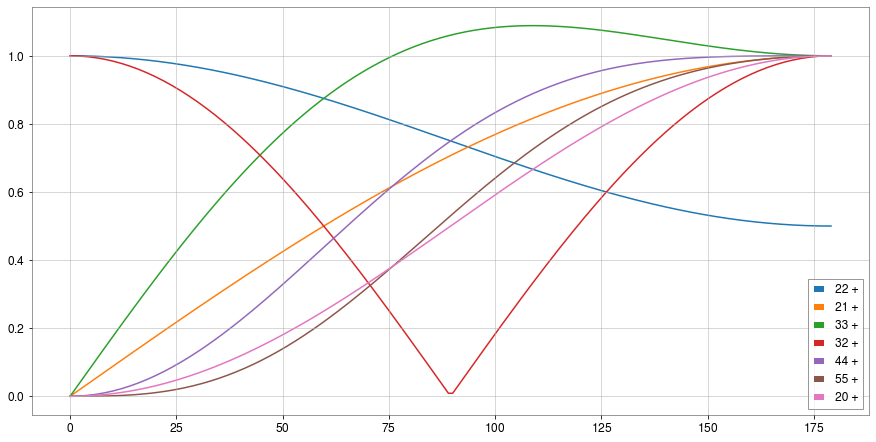

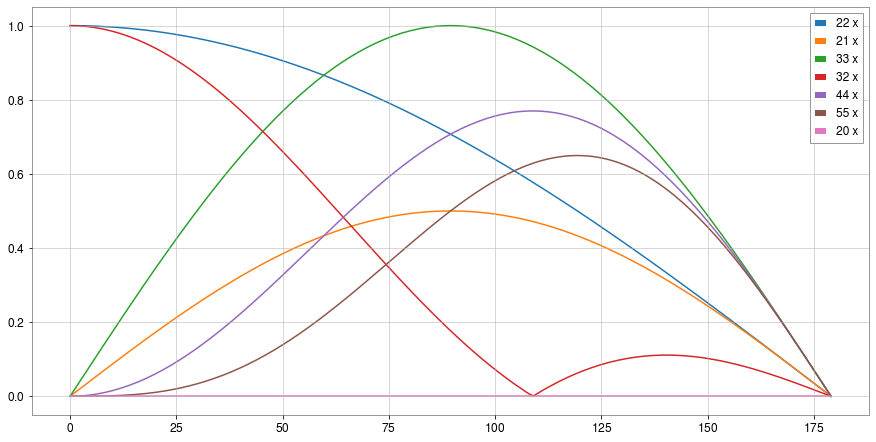

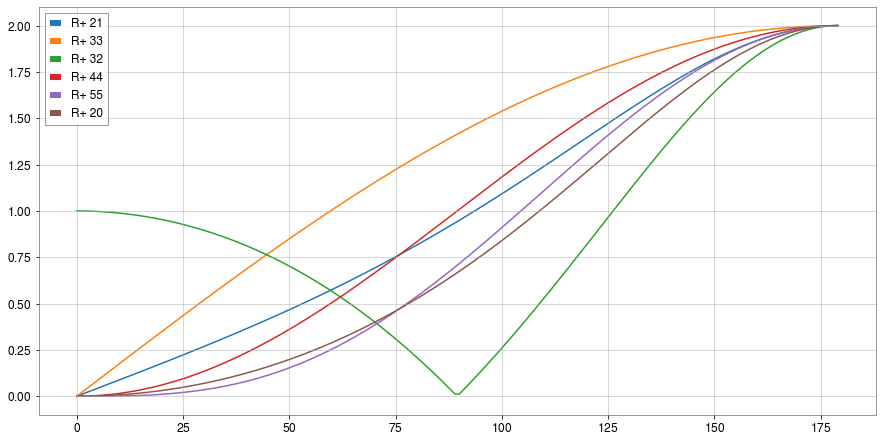

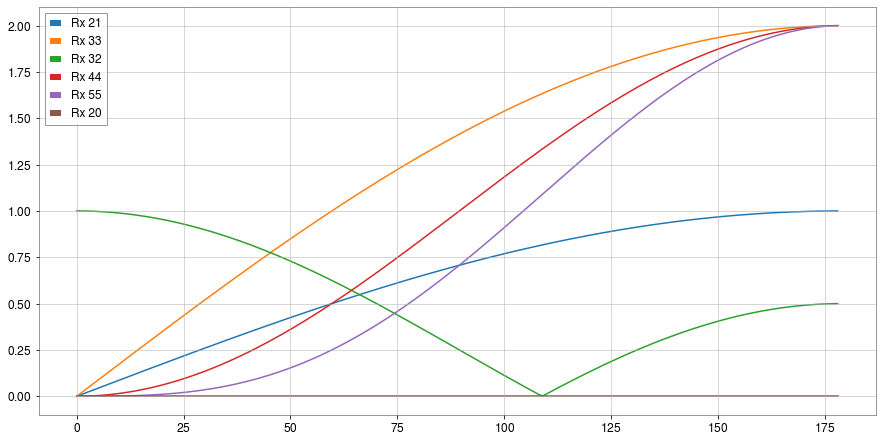

In [11]:
# replicate figure 1 from Mills and Fairhurst
resolution = 180
iota_linspace = np.linspace(0, np.pi/2, num = resolution)
Alm_plus_array = np.zeros((7,resolution),dtype=complex)
Alm_cross_array = np.zeros((7,resolution),dtype=complex)
for k,iota in enumerate(iota_linspace):
    ylm_obj = Ylm_wrapper(iota,0) # assume phic = 0 to eliminate complex element
    Aplus_22 = ylm_obj.get_Aplus_lm(2,2)
    Across_22 = ylm_obj.get_Across_lm(2,2)
    Aplus_21 = ylm_obj.get_Aplus_lm(2,1)
    Across_21 = ylm_obj.get_Across_lm(2,1)
    Aplus_20 = ylm_obj.get_Aplus_lm(2,0)
    Across_20 = ylm_obj.get_Across_lm(2,0)
    Aplus_33 = ylm_obj.get_Aplus_lm(3,3)
    Across_33 = ylm_obj.get_Across_lm(3,3)
    Aplus_32 = ylm_obj.get_Aplus_lm(3,2)
    Across_32 = ylm_obj.get_Across_lm(3,2)
    Aplus_44 = ylm_obj.get_Aplus_lm(4,4)
    Across_44 = ylm_obj.get_Across_lm(4,4)
    Aplus_55 = ylm_obj.get_Aplus_lm(5,5)
    Across_55 = ylm_obj.get_Across_lm(5,5)
    Alm_plus_array[0,k] = Aplus_22
    Alm_plus_array[1,k] = Aplus_21
    Alm_plus_array[2,k] = Aplus_33
    Alm_plus_array[3,k] = Aplus_32
    Alm_plus_array[4,k] = Aplus_44
    Alm_plus_array[5,k] = Aplus_55
    Alm_plus_array[6,k] = Aplus_20
    Alm_cross_array[0,k] = Across_22
    Alm_cross_array[1,k] = Across_21
    Alm_cross_array[2,k] = Across_33
    Alm_cross_array[3,k] = Across_32
    Alm_cross_array[4,k] = Across_44
    Alm_cross_array[5,k] = Across_55
    Alm_cross_array[6,k] = Across_20

modes_labels = ["22","21","33","32","44","55","20"]

Alm_plus_norm = copy(Alm_plus_array)
Alm_plus_norm[0,:] /= Alm_plus_array[0,0]
for k in range(1,7):
    Alm_plus_norm[k,:] /= Alm_plus_array[k,-1]
Alm_plus_norm = np.abs(Alm_plus_norm)

Alm_cross_norm = copy(Alm_cross_array)
Alm_cross_norm[0,:] /= Alm_plus_array[0,0]
for k in range(1,7):
    Alm_cross_norm[k,:] /= Alm_plus_array[k,-1]
Alm_cross_norm = np.abs(Alm_cross_norm)

#plot Aplus
pylab.figure(figsize=(15,7.5))
for k,mode in enumerate(modes_labels):
    mode_data = Alm_plus_norm[k,:]
    pylab.plot(mode_data,label=mode+" +")
pylab.legend()
pylab.show()
pylab.close()

#plot Aplus
pylab.figure(figsize=(15,7.5))
for k,mode in enumerate(modes_labels):
    mode_data = Alm_cross_norm[k,:]
    pylab.plot(mode_data,label=mode+" x")
pylab.legend()
pylab.show()
pylab.close()

# plot R+lm
pylab.figure(figsize=(15,7.5))
for k,mode in enumerate(modes_labels[1:]):
    mode_data = Alm_plus_norm[k+1,:] / Alm_plus_norm[0,:]
    pylab.plot(mode_data,label="R+ "+mode)
pylab.legend()
pylab.legend()
pylab.show()

# plot Rxlm
pylab.figure(figsize=(15,7.5))
for k,mode in enumerate(modes_labels[1:]):
    mode_data = Alm_cross_norm[k+1,:-1] / Alm_cross_norm[0,:-1]
    pylab.plot(mode_data,label="Rx "+mode)
pylab.legend()


In [12]:
H1_psd = read_psd_from_txt("aLigo_ascii.dat",basedir="/home/richard.udall/Injection_Study/PSDs/O3/",asd=True)[0]
H1_psd_o3,H1_psd_o3_freqs = read_psd_from_txt("o3_h1.txt",asd=True)

In [2]:
template_args = {
    'mass_1' : 5,
    'mass_2' : 5,
    'spin_1z' : 0,
    'spin_2z' : 0,
    'spin_1x' : 0,
    'spin_1y' : 0,
    'spin_2x' : 0,
    'spin_2y' : 0,
    'theta_jn' : 0,
    'phase' : 0,
    'luminosity_distance' :1000,
    'ra' : 0,
    'dec' : 0,
    'psi' : 0,
    'tc' : 0,
    'mode_array' : None
}

mt_vals = np.arange(5,205,5)
q_vals = np.arange(0.1,1.05,0.05)

alphas = pd.DataFrame(np.zeros((len(mt_vals),len(q_vals))),index=mt_vals,columns=q_vals)

for i,mt in enumerate(mt_vals):
    for j,q in enumerate(q_vals):
        args = copy(template_args)
        m1 = mt / (1 + q)
        m2 = mt * q / (1+q)
        args['mass_1'] = m1
        args['mass_2'] = m2
        #hp_H1_22,_ = compute_hphc_td(args_22,"IMRPhenomXHM", 1 / 4096, 20)
        hlmps, hlmcs = compute_htildelm_td(args, "IMRPhenomXHM", 1 / 512, fmin=23, fmax = 2047)
        hlmp_22 = hlmps[(2,2)]
        hlmp_33 = hlmps[(3,3)]
        if hlmp_22.delta_f != H1_psd_o3.delta_f:
            H1_psd_o3 = psd_interpolate(H1_psd_o3,hlmp_22.delta_f)
        snr_hlmp_22 = np.sqrt(sigmasq(hlmp_22, psd=H1_psd_o3, low_frequency_cutoff=23, high_frequency_cutoff=2047))
        #snr_hlmp_22 = np.sqrt(my_snr_sq(hlm_22, hlm_22, H1_psd_o3, fmin = 23, fmax = 2047))
        #hp_H1_33,_ = compute_hphc_td(args_33,"IMRPhenomXHM", 1 / 4096, 20)
        if hlmp_33.delta_f != H1_psd_o3.delta_f:
            H1_psd_o3 = psd_interpolate(H1_psd_o3,hlmp_33.delta_f)
        snr_hlmp_33 = np.sqrt(sigmasq(hlmp_33, psd=H1_psd_o3, low_frequency_cutoff=23, high_frequency_cutoff=2047))
        alpha_33 = snr_hlmp_33 / snr_hlmp_22
        alphas.at[mt,q] = alpha_33
        

NameError: name 'pd' is not defined

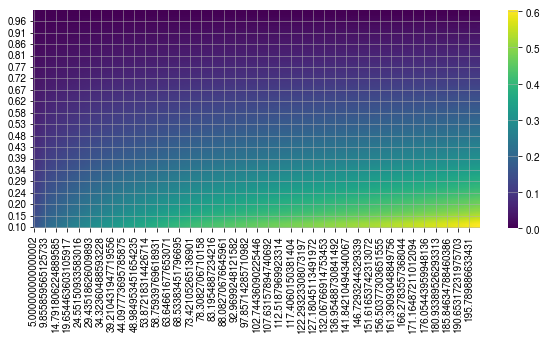

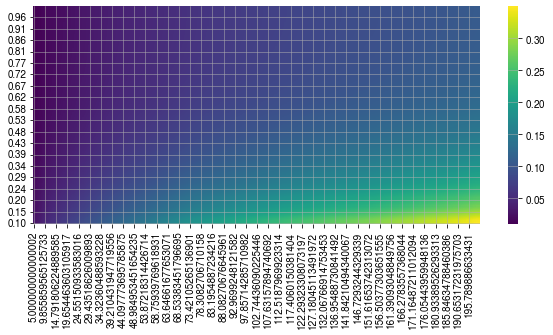

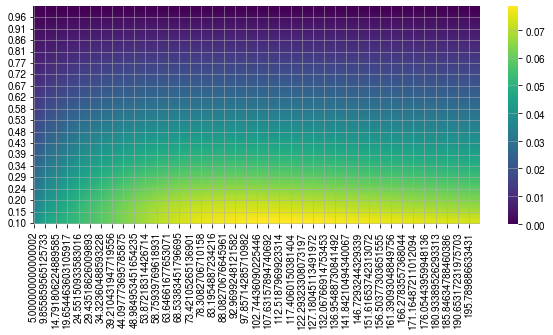

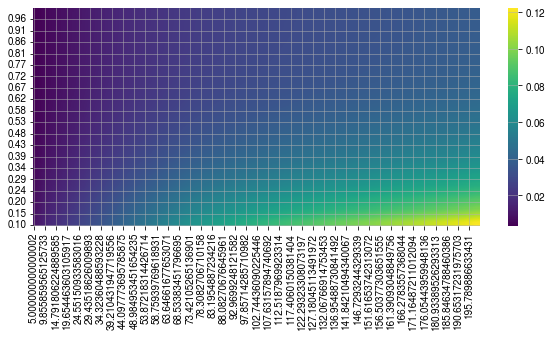

In [63]:
"""
sqrt_wip_22 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(2, 2).csv",index_col=0)
sqrt_wip_33 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(3, 3).csv",index_col=0)
sqrt_wip_21 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(2, 1).csv",index_col=0)
sqrt_wip_32 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(3, 2).csv",index_col=0)
sqrt_wip_44 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(4, 4).csv",index_col=0)
sqrt_wip_2n2 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(2, -2).csv",index_col=0)
sqrt_wip_3n3 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(3, -3).csv",index_col=0)
sqrt_wip_2n1 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(2, -1).csv",index_col=0)
sqrt_wip_3n2 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(3, -2).csv",index_col=0)
sqrt_wip_4n4 = pd.read_csv("IMRPhenomXHM_3/IMRPhenomXHM_sqrt_wip_(4, -4).csv",index_col=0)
"""
base_path = "IMRPhenomHM/IMRPhenomHM"
sqrt_wip_22 = pd.read_csv(f"{base_path}_sqrt_wip_(2, 2).csv",index_col=0)
sqrt_wip_33 = pd.read_csv(f"{base_path}_sqrt_wip_(3, 3).csv",index_col=0)
sqrt_wip_21 = pd.read_csv(f"{base_path}_sqrt_wip_(2, 1).csv",index_col=0)
sqrt_wip_32 = pd.read_csv(f"{base_path}_sqrt_wip_(3, 2).csv",index_col=0)
sqrt_wip_44 = pd.read_csv(f"{base_path}_sqrt_wip_(4, 4).csv",index_col=0)
sqrt_wip_2n2 = pd.read_csv(f"{base_path}_sqrt_wip_(2, -2).csv",index_col=0)
sqrt_wip_3n3 = pd.read_csv(f"{base_path}_sqrt_wip_(3, -3).csv",index_col=0)
sqrt_wip_2n1 = pd.read_csv(f"{base_path}_sqrt_wip_(2, -1).csv",index_col=0)
sqrt_wip_3n2 = pd.read_csv(f"{base_path}_sqrt_wip_(3, -2).csv",index_col=0)
sqrt_wip_4n4 = pd.read_csv(f"{base_path}_sqrt_wip_(4, -4).csv",index_col=0)

alphas_33 = sqrt_wip_33 / sqrt_wip_22
alphas_32 = sqrt_wip_32 / sqrt_wip_22
alphas_44 = sqrt_wip_44 / sqrt_wip_22
alphas_21 = sqrt_wip_21 / sqrt_wip_22

data =  alphas_33.to_numpy()
data = zoom(data, 10)
q = alphas_33.columns
q = [float(val) for val in q]
mtotal = alphas_33.index
mtotal = [float(val) for val in mtotal]
q = zoom(q,10)
mtotal = zoom(mtotal,10)
alphas_33 = pd.DataFrame(data,index=mtotal,columns=q)

data =  alphas_32.to_numpy()
data = zoom(data, 10)
q = alphas_32.columns
q = [float(val) for val in q]
mtotal = alphas_32.index
mtotal = [float(val) for val in mtotal]
q = zoom(q,10)
mtotal = zoom(mtotal,10)
alphas_32 = pd.DataFrame(data,index=mtotal,columns=q)

data =  alphas_44.to_numpy()
data = zoom(data, 10)
q = alphas_44.columns
q = [float(val) for val in q]
mtotal = alphas_44.index
mtotal = [float(val) for val in mtotal]
q = zoom(q,10)
mtotal = zoom(mtotal,10)
alphas_44 = pd.DataFrame(data,index=mtotal,columns=q)

data =  alphas_21.to_numpy()
data = zoom(data, 10)
q = alphas_21.columns
q = [float(val) for val in q]
mtotal = alphas_21.index
mtotal = [float(val) for val in mtotal]
q = zoom(q,10)
mtotal = zoom(mtotal,10)
alphas_21 = pd.DataFrame(data,index=mtotal,columns=q)

#alphas_33 = (sqrt_wip_33 + sqrt_wip_3n3) / (sqrt_wip_22 + sqrt_wip_2n2)
#alphas_32 = (sqrt_wip_32 + sqrt_wip_3n2) / (sqrt_wip_22 + sqrt_wip_2n2)
#alphas_44 = (sqrt_wip_44 + sqrt_wip_4n4) / (sqrt_wip_22 + sqrt_wip_2n2)
#alphas_21 = (sqrt_wip_21 + sqrt_wip_2n1) / (sqrt_wip_22 + sqrt_wip_2n2)

fig, ax1 = plt.subplots(figsize=(10,4))
sns.heatmap(alphas_33.transpose(),cmap="viridis")
#sns.kdeplot(x=alphas_33_restruct.mass_ratio, y=alphas_33.total_mass, cmap="Blues", shade=True, thresh=0)
ax1.invert_yaxis()
ax1.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax1.get_yticklabels()])
plt.show()
plt.close()

fig, ax1 = plt.subplots(figsize=(10,4))
sns.heatmap(alphas_44.transpose(),cmap="viridis")
ax1.invert_yaxis()
ax1.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax1.get_yticklabels()])
plt.show()
plt.close()

fig, ax1 = plt.subplots(figsize=(10,4))
sns.heatmap(alphas_21.transpose(),cmap="viridis")
ax1.invert_yaxis()
ax1.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax1.get_yticklabels()])
plt.show()
plt.close()

fig, ax1 = plt.subplots(figsize=(10,4))
sns.heatmap(alphas_32.transpose(),cmap="viridis")
ax1.invert_yaxis()
ax1.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax1.get_yticklabels()])
plt.show()
plt.close()





In [31]:
alphas_33_restruct_dict = alphas_33.to_dict()
alphas_33_restruct = pd.DataFrame(columns=['mass_ratio','total_mass','alpha_33'])
for q, valdict in alphas_33_restruct_dict.items():
    for mtotal, val in valdict.items():
        alphas_33_restruct = alphas_33_restruct.append({'mass_ratio':round(float(q),3),'total_mass':int(mtotal),'alpha_33':float(val)},ignore_index=True)

     mass_ratio  total_mass  alpha_33
0           0.1         5.0  0.149693
1           0.1        10.0  0.187069
2           0.1        15.0  0.213666
3           0.1        20.0  0.235238
4           0.1        25.0  0.253876
..          ...         ...       ...
755         1.0       180.0  0.000000
756         1.0       185.0  0.000000
757         1.0       190.0  0.000000
758         1.0       195.0  0.000000
759         1.0       200.0  0.000000

[760 rows x 3 columns]


            0.100000  0.100754  0.102889  0.106216  0.110545  0.115685  \
5.000000    0.010114  0.010095  0.010043  0.009962  0.009856  0.009732   
5.079322    0.010200  0.010182  0.010129  0.010047  0.009941  0.009816   
5.303614    0.010443  0.010424  0.010370  0.010287  0.010179  0.010052   
5.652368    0.010819  0.010800  0.010745  0.010659  0.010548  0.010417   
6.105076    0.011305  0.011285  0.011228  0.011139  0.011025  0.010889   
...              ...       ...       ...       ...       ...       ...   
198.894924  0.110956  0.110523  0.109304  0.107418  0.104981  0.102113   
199.347632  0.111153  0.110719  0.109497  0.107606  0.105163  0.102287   
199.696386  0.111304  0.110870  0.109646  0.107750  0.105303  0.102422   
199.920678  0.111402  0.110967  0.109741  0.107844  0.105393  0.102508   
200.000000  0.111437  0.111001  0.109775  0.107877  0.105425  0.102539   

            0.121449  0.127645  0.134084  0.140576  ...  0.959424  0.965916  \
5.000000    0.009594  0.009446  

In [22]:
GT0779_template_args = {
    'mass_1' : 36,
    'mass_2' : 29,
    'spin_1z' : 0,
    'spin_2z' : 0,
    'spin_1x' : 0,
    'spin_1y' : 0,
    'spin_2x' : 0,
    'spin_2y' : 0,
    'theta_jn' : 0,
    'phase' : 0,
    'luminosity_distance' :410,
    'ra' : 0,
    'dec' : 0,
    'psi' : 0,
    'tc' : 0,
    'eccentricity' : 0,
    'mode_array' : None
    
}


#data = RIFT_lal_binary_black_hole(frequency_array,GT0779_template_args,'EccentricityTD')
#data_22 = TimeSeries(data[(2,2)].data.data, epoch = data[(2,2)].epoch, delta_t = data[(2,2)].deltaT)


strain,_,_ = compute_strain_td(GT0779_template_args,"","H1",1/16384,25,1186742405.088623)

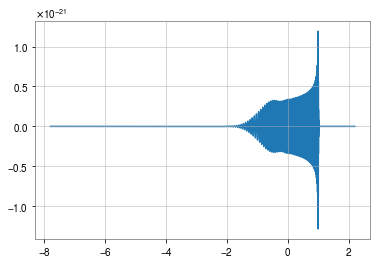

In [19]:
pylab.plot(strain.sample_times,strain)

In [24]:
#test = matched_filter_core(strain,strain,psd=H1_psd,low_frequency_cutoff=10,high_frequency_cutoff=2047)
snr = my_snr_sq(strain,strain,psd=H1_psd)

ValueError: lengths do not match (32676 vs 16292)

In [14]:
df = sns.load_dataset('iris')
print(df)

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]
